### Imports

In [1]:
import pandas as pd
import json
import os, sys
from tqdm import tqdm
import numpy as np
import polars as pl
from polars import col as c
from pprint import pprint
import matplotlib.pyplot as plt
import re

sys.path.append("../")
pl.Config.set_tbl_rows(50)

polars.config.Config

### table creation

In [2]:
dir_path = "../data/parsed_dataframes"
file_name = "epic_records_8500.parquet"
file_path = os.path.join(dir_path, file_name)
epic_records = pd.read_parquet(file_path)

In [3]:
for column in epic_records.columns:
    epic_records[column] = epic_records[column].replace(to_replace="nan", value=np.nan)
    epic_records[column] = pd.to_numeric(epic_records[column], errors="ignore")

/var/folders/v_/vqhfnf3s4sb7g6nfby7hc9sr0000gn/T/ipykernel_81476/633498768.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  epic_records[column] = pd.to_numeric(epic_records[column], errors="ignore")


In [4]:
epic_records.head(2)

,patient_id,record,gender,birthday,amnez_life,amnez_disease,condition,ward_table,full_wards,final_table1,...,secondary_disease_desc,complication_of_main_disease_code,main_disease_code,secondary_disease_code,Дата поступления,gospitalisation_type,gospitalisation_delivery,background_disease_desc,background_disease_code,Конкурирующее заболевание
0,75DB9BE5-92BE-432F-AA97-2CC5A56B8BBC,EMD_EPIC_DISCHARGE_185171131_185171131,Мужской,20000101,ОБЩЕБИОГРАФИЧЕСКИЕ СВЕДЕНИЯ НА СЕВЕРЕ ДАВНО \...,"АНАМНЕЗ ИБС С 2016Г., КОГДА ПЕРЕНЕС ОСТРЫЙ ИМ ...","['Состояние: Средней тяжести', 'Жалобы: НА МОМ...","{'Название': {0: 'Приемное отделение', 1: 'Кар...",{'Сведения о пребывании пациента в Приемное от...,{'Характер основного заболевания': {0: 'Острое...,...,"Сахарный диабет 2 типа, инсулиннезависимый. Це...",['I50.9'],['I20.0'],"['I10', 'E11.8', 'E66.9']",03.04.2023 12:00,Первичный,Плановая госпитализация,NaN,NaN,NaN
1,55218D18-4928-6138-E055-000000000001,EMD_EPIC_DISCHARGE_145291569_145291569,Мужской,20000101,АНАМНЕЗ ЖИЗНИ:,АНАМНЕЗ ЗАБОЛЕВАНИЯ ИБС С 1986 ГОДА КОГДА ВПЕ...,"['Состояние: Удовлетворительное', 'Жалобы: ЖАЛ...","{'Название': {0: 'Приемное отделение', 1: 'Кар...",{'Сведения о пребывании пациента в Приемное от...,{'Характер основного заболевания': {0: 'Острое...,...,Хронический гепатит В без дельта-агента минима...,"['I48.0', 'I50.1']",['I21.0'],"['I69.4', 'B18.0', 'I85.9']",19.01.2019 09:46,Первичный,Доставлен бригадой скорой помощи,"Гипертоническая болезнь III стадии, Артериальн...",['I11.9'],NaN


In [5]:
epic_records = (
    pl.from_pandas(epic_records)
    .with_columns(
        c("Дата поступления")
        .cast(pl.String)
        .str.to_datetime("%d.%m.%Y %H:%M")
        .dt.date(),
        # c("lab_date").cast(pl.String).str.to_datetime("%d.%m.%Y %H:%M").dt.date(),
    )
    .rename({"Дата поступления": "admission_datetime"})
    .drop(["birthday", "record"])
    # .head(2)
)

### create target

In [6]:
# all desease codes
(
    epic_records.filter(
        epic_records.select("patient_id").is_duplicated(),
    )
    .select(["main_disease_desc", "main_disease_code"])
    .with_columns(c("main_disease_code").str.slice(offset=2, length=3))[
        "main_disease_code"
    ]
    .value_counts()
    .sort(
        "count",
        descending=True,
    )
)

main_disease_code,count
str,u32
"""I20""",1142
"""I21""",1042
"""I25""",10
"""I50""",7
"""I11""",5
"""I47""",3
"""I22""",3
"""I48""",2
"""I70""",1


In [7]:
epic_records_with_target = (
    epic_records.filter(
        epic_records.select("patient_id").is_duplicated(),
    )
    .with_columns(
        c("main_disease_code").str.slice(
            offset=2,
            length=3,
        )
    )
    .group_by("patient_id")
    .agg(
        pl.all().sort_by("admission_datetime").first(),
        c("admission_datetime")
        .sort_by("admission_datetime")
        .alias("following_admission_datetimes"),
        c("main_disease_code")
        .sort_by("admission_datetime")
        .alias("following_main_disease_codes"),
    )
    .with_columns(
        c("following_admission_datetimes").list.slice(offset=1),
        c("following_main_disease_codes").list.slice(offset=1),
    )
    .with_columns(
        pl.when(c("following_main_disease_codes").list.contains("I21"))
        .then(1)
        .when(c("following_main_disease_codes").list.contains("I22"))
        .then(1)
        .otherwise(0)
        .alias("target")
    )
)
epic_records_with_target.sample(3)

patient_id,gender,amnez_life,amnez_disease,condition,ward_table,full_wards,final_table1,final_table2,complication_of_main_disease_desc,main_disease_desc,secondary_disease_desc,complication_of_main_disease_code,main_disease_code,secondary_disease_code,admission_datetime,gospitalisation_type,gospitalisation_delivery,background_disease_desc,background_disease_code,Конкурирующее заболевание,following_admission_datetimes,following_main_disease_codes,target
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,date,str,str,str,str,str,list[date],list[str],i32
"""9A626AF6-C17D-4A04-AC0E-716B72…","""Мужской""","""Б""","""СЧИТАЕТ СЕБЯ БОЛЬНЫМ С 25.12.2…","""['Состояние: Средней тяжести',…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН 1 по Killip.""","""ИБС. Острый инфаркт миокарда п…","""Пароксизмальная форма фибрилля…","""['I50.1']""","""I21""","""['I48.0', 'I70.8', 'I70.2', 'E…",2022-12-25,"""Первичный""","""Плановая госпитализация""","""Гипертоническая болезнь III ст…","""['I11.9']""",null,[2023-01-04],"[""I21""]",1
"""5C81816A-2808-7A86-E055-000000…","""Мужской""","""Б""","""АНАМНЕЗ ЗАБОЛЕВАНИЯ КЛИНИКА И…","""['Состояние: Удовлетворительно…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН 1 по Killip.""","""ОКС без подьема сегмента ST. …","""Атеросклероз брахиоцефальных а…","""['I50.1']""","""I20""","""['I70.8', 'E66.9']""",2022-06-08,"""Первичный""","""Плановая госпитализация""","""Гипертоническая болезнь III ст…","""['E11.9', 'I11.9']""",null,"[2022-11-29, 2023-11-05]","[""I20"", ""I20""]",0
"""5A6481F4-6A1D-7AD5-E055-000000…","""Мужской""","""АНАМНЕЗ ЖИЗНИ:""","""АНАМНЕЗ ЗАБОЛЕВАНИЯ РАНЕЕ ИБС…","""['Состояние: Удовлетворительно…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН VI по Kiillip. Кардиогенны…","""ИБС. Инфаркт нижней стенки мио…",null,"""['I50.1']""","""I21""",null,2020-07-10,"""Первичный""","""Доставлен бригадой скорой помо…",null,null,null,[2020-11-17],"[""I20""]",0


### make features

In [8]:
epic_records_with_target.shape

(991, 24)

In [9]:
epic_records_with_target.null_count()

patient_id,gender,amnez_life,amnez_disease,condition,ward_table,full_wards,final_table1,final_table2,complication_of_main_disease_desc,main_disease_desc,secondary_disease_desc,complication_of_main_disease_code,main_disease_code,secondary_disease_code,admission_datetime,gospitalisation_type,gospitalisation_delivery,background_disease_desc,background_disease_code,Конкурирующее заболевание,following_admission_datetimes,following_main_disease_codes,target
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,10,0,192,10,0,192,0,0,0,135,135,986,0,0,0


In [10]:
epic_records_with_target.head(1)

patient_id,gender,amnez_life,amnez_disease,condition,ward_table,full_wards,final_table1,final_table2,complication_of_main_disease_desc,main_disease_desc,secondary_disease_desc,complication_of_main_disease_code,main_disease_code,secondary_disease_code,admission_datetime,gospitalisation_type,gospitalisation_delivery,background_disease_desc,background_disease_code,Конкурирующее заболевание,following_admission_datetimes,following_main_disease_codes,target
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,date,str,str,str,str,str,list[date],list[str],i32
"""C8D18143-01F0-414F-B642-64A5DA…","""Мужской""","""Б""","""СЧИТАЕТ СЕБЯ БОЛЬНЫМ В ТЕЧЕНИЕ…","""['Состояние: Удовлетворительно…","""{'Название': {0: 'Приемное отд…","""{'Сведения о пребывании пациен…","""{'Характер основного заболеван…","""{'Вид нозологической единицы':…","""ОСН I по Killip""","""ОКС с подъемом сегмента ST. Си…",null,"""['I50.1']""","""I21""",null,2022-09-19,"""Первичный""","""Доставлен бригадой скорой помо…","""СД 2 типа, целевой уровень гли…","""['E11.8', 'I11.9']""",null,[2022-09-27],"[""I21""]",1


#### final_table2

In [11]:
pd.DataFrame(eval(epic_records_with_target["final_table2"].to_numpy()[0]))

,Вид нозологической единицы,Врачебное описание нозологической единицы,Код по МКБ-10
0,Основное заболевание,ИБС. Острый инфаркт миокарда с зубцом Q передн...,I21.0
1,Основное заболевание,ИБС. Острый инфаркт миокарда с зубцом Q передн...,I21.0
2,Осложнение основного заболевания,ОСН I по Killip,I50.1
3,Конкурирующее заболевание,Носительство возбудителя новой коронавирусной ...,Z22.8
4,Фоновое заболевание,Гипертоническая болезнь III стадии. Неконтроли...,I11.9
5,Фоновое заболевание,"СД 2 типа, целевой уровень гликированного гемо...",E11.8


In [12]:
# same values that are already in table

In [13]:
epic_records_with_target = epic_records_with_target.drop("final_table2")

#### competing disease

In [14]:
epic_records_with_target["Конкурирующее заболевание"].unique()

Конкурирующее заболевание
str
"""['J06.9']"""
"""['K92.9']"""
"""['I40.9']"""
"""['I51.4']"""
null
"""['J18.1']"""


In [15]:
epic_records_with_target = epic_records_with_target.with_columns(
    (c("Конкурирующее заболевание").is_not_null() * 1).alias("has_competing_disease")
).drop("Конкурирующее заболевание")

#### final_table1 -> first gospitalization results

In [16]:
# plt.hist
pl.from_pandas(
    pd.DataFrame(
        eval(
            epic_records_with_target.with_columns(
                c("final_table1").str.len_chars().alias("fdsa")
            )
            .sort(["fdsa"])["final_table1"]
            .to_numpy()[241]
        )
    )
)

Характер основного заболевания,Исход госпитализации,Результат обращения,Признак подозрения на злокачественное новообразование,Признак развертывания индивидуального поста
str,str,str,str,str
"""Острое""","""None""","""Улучшение""","""Нет""","""Нет"""


In [17]:
def search_condition(x):

    try:
        found = re.search(
            r"Признак развертывания индивидуального поста\':\s{0:\s\'(\D*)\'}",
            x,
        ).group(1)
    except AttributeError:
        # match not found in the original string
        found = ""  # apply your error handling
    return found


(
    epic_records_with_target.with_columns(
        c("final_table1")
        .map_elements(
            search_condition,
            return_dtype=str,
        )
        .alias("main_desease_status")
    )["main_desease_status"]
    .value_counts()
    .sort("count", descending=True)
)

main_desease_status,count
str,u32
"""Нет""",991


In [18]:
def search_condition(x):

    try:
        found = re.search(
            r"Признак подозрения на злокачественное новообразование\':\s{0:\s\'(\D*)\'}",
            x,
        ).group(1)
    except AttributeError:
        # match not found in the original string
        found = ""  # apply your error handling
    return found


(
    epic_records_with_target.with_columns(
        c("final_table1")
        .map_elements(
            search_condition,
            return_dtype=str,
        )
        .alias("main_desease_status")
    )["main_desease_status"]
    .value_counts()
    .sort("count", descending=True)
)

main_desease_status,count
str,u32
"""Нет""",991


In [19]:
def search_condition(x):

    try:
        found = re.search(
            r"Результат обращения\':\s{0:\s\'(\D*)\'}",
            x,
        ).group(1)
    except AttributeError:
        # match not found in the original string
        found = ""  # apply your error handling
    return found


epic_records_with_target = epic_records_with_target.with_columns(
    c("final_table1")
    .map_elements(
        search_condition,
        return_dtype=str,
    )
    .alias("gospitalization_result")
)
epic_records_with_target["gospitalization_result"].value_counts()

gospitalization_result,count
str,u32
"""Улучшение""",961
"""Ухудшение""",2
"""Без изменения""",28


In [20]:
def search_condition(x):

    try:
        found = re.search(
            r"Исход госпитализации\':\s{0:\s\'(\D*)\'}",
            x,
        ).group(1)
    except AttributeError:
        # match not found in the original string
        found = ""  # apply your error handling
    return found


(
    epic_records_with_target.with_columns(
        c("final_table1")
        .map_elements(
            search_condition,
            return_dtype=str,
        )
        .alias("main_desease_status")
    )["main_desease_status"]
    .value_counts()
    .sort("count", descending=True)
)

main_desease_status,count
str,u32
"""None""",991


In [21]:
def search_condition(x):

    try:
        found = re.search(
            r"Характер основного заболевания\':\s{0:\s\'(\D*)\'}",
            x,
        ).group(1)
    except AttributeError:
        # match not found in the original string
        found = ""  # apply your error handling
    return found


epic_records_with_target = epic_records_with_target.with_columns(
    c("final_table1")
    .map_elements(
        search_condition,
        return_dtype=str,
    )
    .alias("main_desease_status")
)
epic_records_with_target["main_desease_status"].value_counts()

main_desease_status,count
str,u32
"""Острое""",951
"""Ранее установленное хроническо…",24
"""None""",16


In [22]:
epic_records_with_target = epic_records_with_target.drop("final_table1")

#### condition

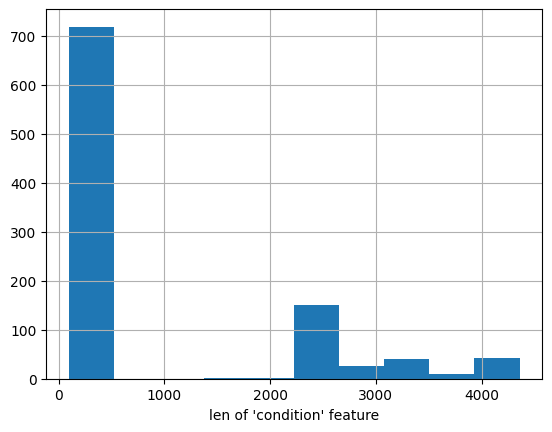

In [23]:
plt.hist(
    epic_records_with_target.with_columns(c("condition").str.len_chars().alias("fdsa"))
    .sort(["fdsa"])["fdsa"]
    .to_numpy()
    # [140]
)
plt.xlabel("len of 'condition' feature")
plt.grid()

In [24]:
def search_condition(x):

    try:
        found = re.search(
            r"Состояние:\s*(.{2,24})',",
            x,
        ).group(1)
    except AttributeError:
        # match not found in the original string
        found = ""  # apply your error handling
    return found


epic_records_with_target = epic_records_with_target.with_columns(
    c("condition")
    .map_elements(
        search_condition,
        return_dtype=str,
    )
    .alias("condition_status")
)
epic_records_with_target["condition_status"].unique()

condition_status
str
"""Тяжелое"""
"""Средней тяжести"""
"""Крайне тяжелое"""
"""Удовлетворительное"""


In [88]:
def search_condition(x):

    try:
        found = re.search(
            r"ИМТ\D*(\d+)",
            x,
        ).group(1)
    except AttributeError:
        # match not found in the original string
        found = ""  # apply your error handling
    return found


(
    epic_records_with_target.with_columns(
        c("condition")
        .map_elements(
            search_condition,
            return_dtype=str,
        )
        .alias("BMI")
    )["BMI"]
    .value_counts()
    .sort("count", descending=True)
    .head()
)

BMI,count
str,u32
"""""",753
"""28""",22
"""30""",21
"""29""",20
"""24""",19


In [26]:
def search_condition(x):

    try:
        found = re.search(
            r"НАСЫЩЕНИЕ КРОВИ КИСЛОРОДОМ \(САТУРАЦИЯ, %\)\D*(\d+)",
            x,
        ).group(1)
    except AttributeError:
        # match not found in the original string
        found = ""  # apply your error handling
    return found


(
    epic_records_with_target.with_columns(
        c("condition")
        .map_elements(
            search_condition,
            return_dtype=str,
        )
        .alias("oxygen")
    )["oxygen"]
    .value_counts()
    .sort("count", descending=True)
)

oxygen,count
str,u32
"""""",825
"""98""",91
"""97""",25
"""96""",17
"""99""",11
"""95""",10
"""93""",2
"""88""",2
"""89""",2


In [27]:
def clean_condition(x):
    b = re.sub(
        r"'\Состояние:\s*(.{2,24})\',",
        " ",
        x,
    )
    b = re.sub(
        r"\\n",
        " ",
        b,
    )
    b = re.sub(
        r"  +",
        " ",
        b,
    )
    return b


epic_records_with_target = (
    epic_records_with_target.with_columns(
        c("condition").map_elements(
            clean_condition,
            return_dtype=str,
        )
    )
    # ["full_wards"]
    # .value_counts()
    # .sort("count", descending=True)
    # .to_numpy()
    # [0]
)

#### full wards

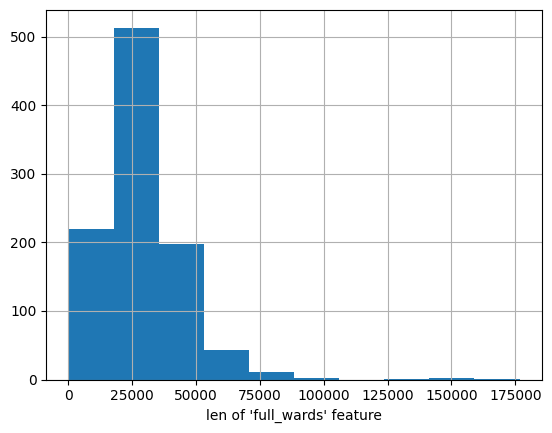

In [28]:
plt.hist(
    epic_records_with_target.with_columns(c("full_wards").str.len_chars().alias("fdsa"))
    .sort(["fdsa"])["fdsa"]
    .to_numpy()
    # [140]
)
plt.xlabel("len of 'full_wards' feature")
plt.grid()

In [29]:
def clean_full_wards(x):
    x = x.replace("!", "")
    x = re.sub(
        r"{urn:hl7-org:v3}",
        " ",
        x,
    )
    x = re.sub(
        r"\'\D+\':",
        " ",
        x,
    )
    x = re.sub(
        r"[\\n{}\'\"]",
        " ",
        x,
    )
    x = re.sub(
        r"  +",
        " ",
        x,
    )
    return x


epic_records_with_target = (
    epic_records_with_target.with_columns(
        c("full_wards").map_elements(
            clean_full_wards,
            return_dtype=str,
        )
    )
    # ["full_wards"]
    # .value_counts()
    # .sort("count", descending=True)
    # .to_numpy()
    # [0]
)

In [30]:
def search_condition(x):

    try:
        found = re.search(
            r"ДАТА РОЖДЕНИЯ\):\s(\d{2}) ",
            x,
        ).group(1)
    except AttributeError:
        # match not found in the original string
        found = ""  # apply your error handling
    return found


epic_records_with_target = epic_records_with_target.with_columns(
    c("full_wards")
    .map_elements(
        search_condition,
        return_dtype=str,
    )
    .alias("age")
)

In [31]:
def search_condition(x):

    try:
        found = re.search(
            r"ЧСС\s*[-,:РАВЕН]*\s*(\d{2,4})",
            x,
        ).group(1)
    except AttributeError:
        # match not found in the original string
        found = ""  # apply your error handling
    return found


epic_records_with_target = epic_records_with_target.with_columns(
    c("full_wards")
    .map_elements(
        search_condition,
        return_dtype=str,
    )
    .alias("heart_rate")
)
(
    epic_records_with_target["heart_rate"].value_counts().sort("count", descending=True)
).head(5)

heart_rate,count
str,u32
"""68""",51
"""64""",46
"""76""",43
"""""",35
"""72""",33


In [32]:
def search_condition(x):

    try:
        found = re.search(
            r"ИМТ\D*(\d+)",
            x,
        ).group(1)
    except AttributeError:
        # match not found in the original string
        found = ""  # apply your error handling
    return found


epic_records_with_target = epic_records_with_target.with_columns(
    c("full_wards")
    .map_elements(
        search_condition,
        return_dtype=str,
    )
    .alias("BMI")
)
(epic_records_with_target["BMI"].value_counts().sort("count", descending=True).head())

BMI,count
str,u32
"""""",565
"""31""",37
"""32""",35
"""28""",33
"""30""",30


In [33]:
def search_condition(x):

    try:
        found = re.search(
            r"ПРАВОЕ ПРЕДСЕРДИЕ:*[\sНЕОТЧЕТЛИВО]*\s*(\d[,.]{0,1}\d{0,1})",
            x,
        ).group(1)
    except AttributeError:
        # match not found in the original string
        found = ""  # apply your error handling
    return found


epic_records_with_target = epic_records_with_target.with_columns(
    c("full_wards")
    .map_elements(
        search_condition,
        return_dtype=str,
    )
    .alias("right atrium")
)
(
    epic_records_with_target["right atrium"]
    .value_counts()
    .sort("count", descending=True)
    .head(10)
)

right atrium,count
str,u32
"""3,5""",162
"""3,6""",149
"""3,4""",106
"""3,8""",75
"""3,3""",72
"""3,7""",66
"""3,2""",50
"""3,9""",41
"""""",30


#### ward_table

In [34]:
pd.DataFrame(eval(epic_records_with_target["ward_table"].to_numpy()[920]))

,Название,Дата поступления,Дата перевода,Профиль койки,Лечащий врач
0,Приемное отделение,20.09.2020 21:40,20.09.2020 21:49,!!!!!!!!!!!!! !!!!!!!!!!!!! ! (Врач-кардиолог),None
1,Кардиологическое отделение с ПРиИТ для лечения...,20.09.2020 21:50,20.09.2020 22:06,!!!!!!!!!!!!! !!!!!!!!!!!!! !!!!!!!!!!!!! (Зав...,None
2,Отделение анестезиологии-реанимации с палатами...,20.09.2020 22:07,21.09.2020 12:10,!!!!!!!!!!!!! !!!!!!!!!!!!! ! (Врач-анестезиол...,None
3,Кардиологическое отделение с ПРиИТ для лечения...,21.09.2020 12:11,29.09.2020 09:00,!!!!!!!!!!!!! !!!!!!!!!!!!! !!!!!!!!!!!!! (Зав...,None


In [35]:
pd.DataFrame(
    eval(epic_records_with_target["ward_table"].to_numpy()[920].replace("!", ""))
)

,Название,Дата поступления,Дата перевода,Профиль койки,Лечащий врач
0,Приемное отделение,20.09.2020 21:40,20.09.2020 21:49,(Врач-кардиолог),None
1,Кардиологическое отделение с ПРиИТ для лечения...,20.09.2020 21:50,20.09.2020 22:06,(Заведующий (начальник) структурного подраз...,None
2,Отделение анестезиологии-реанимации с палатами...,20.09.2020 22:07,21.09.2020 12:10,(Врач-анестезиолог-реаниматолог),None
3,Кардиологическое отделение с ПРиИТ для лечения...,21.09.2020 12:11,29.09.2020 09:00,(Заведующий (начальник) структурного подраз...,None


In [36]:
# empty field
d = list(
    map(
        lambda x: set(
            pd.DataFrame(eval(x.replace("!", "")))["Лечащий врач"].values.tolist()
        ),
        epic_records_with_target["ward_table"].to_numpy(),
    )
)
set().union(*d)

{'None'}

In [37]:
def search_condition(x):

    found = re.sub(
        r", \'Лечащий врач\':.*\'None\'}",
        "",
        x.replace("!", ""),
    )
    found = re.sub(
        " +",
        " ",
        found,
    )

    return found


epic_records_with_target = epic_records_with_target.with_columns(
    c("ward_table").map_elements(
        search_condition,
        return_dtype=str,
    )
    # .alias("condition_status")
)
eval(epic_records_with_target["ward_table"].to_numpy()[0])

{'Название': {0: 'Приемное отделение',
  1: 'Кардиологическое отделение с ПРиИТ для лечения больных с ОКС (ПСО) №2',
  2: 'Отделение анестезиологии-реанимации с палатами реанимации и интенсивной терапии №2',
  3: 'Кардиологическое отделение с ПРиИТ для лечения больных с ОКС (ПСО) №2',
  4: 'Отделение анестезиологии-реанимации с палатами реанимации и интенсивной терапии №1',
  5: 'Отделение анестезиологии-реанимации с палатами реанимации и интенсивной терапии №1',
  6: 'Кардиологическое отделение с ПРиИТ для лечения больных с ОКС (ПСО) №2'},
 'Дата поступления': {0: '19.09.2022 07:25',
  1: '19.09.2022 07:35',
  2: '19.09.2022 08:30',
  3: '19.09.2022 15:28',
  4: '19.09.2022 15:31',
  5: '19.09.2022 20:04',
  6: '21.09.2022 09:52'},
 'Дата перевода': {0: '19.09.2022 07:34',
  1: '19.09.2022 08:30',
  2: '19.09.2022 15:28',
  3: '19.09.2022 15:30',
  4: '19.09.2022 20:04',
  5: '21.09.2022 09:51',
  6: '21.09.2022 14:00'},
 'Профиль койки': {0: ' (Врач-кардиолог)',
  1: ' (Заведующий (н

#### main disease code

In [39]:
epic_records_with_target["main_disease_code"].value_counts().sort(
    "count",
    descending=True,
)

main_disease_code,count
str,u32
"""I21""",511
"""I20""",471
"""I48""",2
"""I50""",2
"""I47""",1
"""I70""",1
"""I11""",1
"""I40""",1
"""I25""",1


In [40]:
epic_records_with_target = epic_records_with_target.with_columns(
    ((c("main_disease_code") == "I21") * 1).alias("main_disease_I21"),
    ((c("main_disease_code") == "I20") * 1).alias("main_disease_I20"),
)

#### secondary_disease_code

In [41]:
epic_records_with_target = (
    epic_records_with_target.with_columns(
        c("secondary_disease_code").map_elements(
            lambda x: eval(x),
            return_dtype=list[str],
        ),
        c("background_disease_code").map_elements(
            lambda x: eval(x),
            return_dtype=list[str],
        ),
        c("complication_of_main_disease_code").map_elements(
            lambda x: eval(x),
            return_dtype=list[str],
        ),
    )
    .with_columns(
        c("secondary_disease_code").fill_null([]),
        c("background_disease_code").fill_null([]),
        c("complication_of_main_disease_code").fill_null([]),
    )
    .with_columns(
        # (c("secondary_disease_code").list + c("background_disease_code").list).alias("secondary_and_background_disease_codes")
        pl.concat_list(
            c("secondary_disease_code"),
            c("background_disease_code"),
            c("complication_of_main_disease_code"),
        ).alias("secondary_and_background_disease_codes")
    )
)

epic_records_with_target.select(
    "secondary_disease_code",
    "background_disease_code",
    "complication_of_main_disease_code",
    "secondary_and_background_disease_codes",
).head()

secondary_disease_code,background_disease_code,complication_of_main_disease_code,secondary_and_background_disease_codes
list[str],list[str],list[str],list[str]
[],"[""E11.8"", ""I11.9""]","[""I50.1""]","[""E11.8"", ""I11.9"", ""I50.1""]"
"[""I70.8""]","[""I11.9""]","[""I50.1""]","[""I70.8"", ""I11.9"", ""I50.1""]"
"[""I48.1"", ""E66.9""]","[""I11.9""]","[""I50.1""]","[""I48.1"", ""E66.9"", … ""I50.1""]"
"[""E66.9""]","[""E11.7"", ""I11.9""]","[""I50.9""]","[""E66.9"", ""E11.7"", … ""I50.9""]"
"[""E66.9""]","[""I11.9""]","[""I50.1""]","[""E66.9"", ""I11.9"", ""I50.1""]"


In [42]:
epic_records_with_target = epic_records_with_target.with_columns(
    c("secondary_and_background_disease_codes")
    .map_elements(
        lambda x: len(x),
        return_dtype=int,
    )
    .alias("secondary_and_background_disease_count")
)
epic_records_with_target["secondary_and_background_disease_count"].head(3)

secondary_and_background_disease_count
i64
3
3
4


In [48]:
column = epic_records_with_target["secondary_and_background_disease_codes"].to_list()
flat_list = []

for disease_list in column:
    if disease_list is not None:
        for code in disease_list:
            flat_list.append(code[:3])
disease_codes = list(set(flat_list))

In [49]:
secondary_disease_codes = pd.DataFrame({name: [0] * 991 for name in disease_codes})
secondary_disease_codes.head(3)

,D37,K21,C74,F32,C18,D01,D29,C44,S98,I35,...,N13,I11,I42,I64,E03,M16,R15,H27,I45,K85
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
i = 0
for row in epic_records_with_target.iter_rows(named=True):
    if row["secondary_and_background_disease_codes"]:
        for code in row["secondary_and_background_disease_codes"]:
            secondary_disease_codes.at[i, code[:3]] = 1
    i += 1

In [51]:
epic_records_with_target = epic_records_with_target.with_columns(
    (
        pl.Series(
            name=f"secondary_disease_{column}",
            values=secondary_disease_codes[column].tolist(),
        )
        for column in secondary_disease_codes.columns
    )
)

### convert to dtypes

In [83]:
epic_records_with_target = (
    epic_records_with_target.with_columns(
        c("age").replace({"": None}),
        c("heart_rate").replace({"": None}),
        c("BMI").replace({"": None}),
    )
    .with_columns(
        c("right atrium").str.replace(",", "."),
    )
    .with_columns(
        c("right atrium").replace({"": None}),
    )
    .with_columns(
        c("age").cast(pl.Int64),
        c("heart_rate").cast(pl.Int64),
        c("BMI").cast(pl.Int64),
        c("right atrium").cast(pl.Float64),
    )
    # ["right atrium"]
    # .value_counts()
    # .sort("count", descending=True)
)

### save transformed dataframe

In [85]:
epic_records_with_target.sample(3)

patient_id,gender,amnez_life,amnez_disease,condition,ward_table,full_wards,complication_of_main_disease_desc,main_disease_desc,secondary_disease_desc,complication_of_main_disease_code,main_disease_code,secondary_disease_code,admission_datetime,gospitalisation_type,gospitalisation_delivery,background_disease_desc,background_disease_code,following_admission_datetimes,following_main_disease_codes,target,has_competing_disease,gospitalization_result,main_desease_status,condition_status,age,heart_rate,BMI,right atrium,main_disease_I21,main_disease_I20,secondary_and_background_disease_codes,secondary_and_background_disease_count,seondary_disease_D37,seondary_disease_K21,seondary_disease_C74,seondary_disease_F32,…,seondary_disease_T59,seondary_disease_J67,seondary_disease_I63,seondary_disease_K80,seondary_disease_Q64,seondary_disease_I07,seondary_disease_N21,seondary_disease_N42,seondary_disease_D61,seondary_disease_E79,seondary_disease_B37,seondary_disease_M17,seondary_disease_E10,seondary_disease_E89,seondary_disease_D35,seondary_disease_E04,seondary_disease_K92,seondary_disease_J42,seondary_disease_G20,seondary_disease_G63,seondary_disease_C20,seondary_disease_N23,seondary_disease_D86,seondary_disease_I08,seondary_disease_C64,seondary_disease_C61,seondary_disease_K74,seondary_disease_N13,seondary_disease_I11,seondary_disease_I42,seondary_disease_I64,seondary_disease_E03,seondary_disease_M16,seondary_disease_R15,seondary_disease_H27,seondary_disease_I45,seondary_disease_K85
str,str,str,str,str,str,str,str,str,str,list[str],str,list[str],date,str,str,str,list[str],list[date],list[str],i32,i32,str,str,str,i64,i64,i64,f64,i32,i32,list[str],i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""2D918552-AED3-47D8-82D6-0C0469…","""Мужской""","""АНАМНЕЗ ЖИЗНИ:""","""АНАМНЕЗ ЗАБОЛЕВАНИЯ ИБС, ИМ -…","""[ 'Жалобы: ЖАЛОБЫ НА МОМЕНТ ОС…","""{'Название': {0: 'Приемное отд…",""" , Сведения о пребывании пацие…","""ОСН I по Killip.""","""ИБС. Нестабильная стенокардия.""","""Ожирение 1 степени.""","[""I50.9""]","""I20""","[""E66.9""]",2021-06-22,"""Первичный""","""Плановая госпитализация""","""Сахарный диабет 2 типа. Целево…","[""E11.7"", ""I11.9""]",[2021-07-06],"[""I21""]",1,0,"""Улучшение""","""Острое""","""Удовлетворительное""",57,89,null,3.8,0,1,"[""E66.9"", ""E11.7"", … ""I50.9""]",4,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
"""C255545A-E218-48DB-9725-D62075…","""Мужской""","""Б""","""АНАМНЕЗ ЗАБОЛЕВАНИЯ ИБС РАНЕЕ…","""[ 'Жалобы: ЖАЛОБЫ НА МОМЕНТ ОС…","""{'Название': {0: 'Приемное отд…",""" , Сведения о пребывании пацие…","""ОСН I по Killip.""","""ОКС без подъема сегмента ST""",null,"[""I50.1""]","""I21""",[],2022-06-25,"""Первичный""","""Плановая госпитализация""","""Гипертоническая болезнь III с…","[""I11.9""]",[2024-02-09],"[""I21""]",1,0,"""Улучшение""","""Ранее установленное хроническо…","""Удовлетворительное""",47,79,29,3.3,1,0,"[""I11.9"", ""I50.1""]",2,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
"""4B4705F9-1235-353F-E055-000000…","""Мужской""","""Б""","""АНАМНЕЗ ЗАБОЛЕВАНИЯ ИБС, ИМ- …","""[ 'Жалобы: ЖАЛОБЫ НА МОМЕНТ ОС…","""{'Название': {0: 'Приемное отд…",""" , Сведения о пребывании пацие…","""ОСН по Killip 1""","""Нестабильная стенокардияОКС бе…",null,"[""I50.1""]","""I20""",[],2021-12-17,"""Первичный""","""Доставлен бригадой скорой помо…","""Сахарный диабет 2 типа, уровен…","[""E11.8""]","[2022-10-18, 2023-07-20]","[""I20"", ""I20""]",0,0,"""Улучшение""","""Острое""","""Удовлетворительное""",59,68,null,3.6,0,1,"[""E11.8"", ""I50.1""]",2,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [86]:
epic_records_with_target.shape

(991, 210)

In [87]:
path = "../data/data_for_models"
os.makedirs(path)
file_name = "epic_records_with_target.parquet"
file_path = os.path.join(path, file_name)
epic_records_with_target.write_parquet(file_path)